In [16]:
# IMPORTS
import numpy as np
import pandas as pd
import os

#Fin Data Sources
import kagglehub
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [33]:
def get_1h_data_kg_yf(tickers):
    df_res = pd.DataFrame()

    for crypto in tickers: # ["BTC", "ETH", "XRP"]:
        # step 1. download data from kaggle
        path = kagglehub.dataset_download(f"imranbukhari/comprehensive-{crypto.lower()}usd-1h-data")
        
        # read the downloaded data as df
        df = pd.read_csv(os.path.join(path, f"{crypto}USD_1h_Combined_Index.csv"), index_col=0)
        
        # convert index to datetime and localize to UTC
        df.index = pd.to_datetime(df.index).tz_localize("UTC")

        # step 2. get the end time from the last index
        end_kagg_h = df.index[-1] # a UTC timestamp

        # YF only fetches from the beginning of the day
        end_kagg_day = str(end_kagg_h.date())
        historyPrices = yf.Ticker(f"{crypto}-USD").history(start=end_kagg_day, interval="1h")

        # Filter to start at 1 hour after the end_of_kaggle_hour
        start_yf_h = end_kagg_h + pd.Timedelta(hours=1)
        historyPrices = historyPrices[historyPrices.index >= start_yf_h]

        # Add symbol column for clarity
        df["Ticker"] = crypto
        historyPrices["Ticker"] = crypto

        # step 3. Concatenate and clean
        df = pd.concat([df, historyPrices]).sort_index().drop_duplicates()

        # step 4 merge to the fianl out df
        df_res = pd.concat([df_res, df])

    # drop the two columns not applicabel to Cryptos
    df_res.drop(columns=["Dividends", "Stock Splits"], inplace=True)
           
    return df_res


In [34]:
tickers = ["BTC", "ETH", "XRP"]
df_res = get_1h_data_kg_yf(tickers)

In [35]:
df_res

,Open,High,Low,Close,Volume,Ticker
2011-08-18 12:37:00+00:00,10.900000,10.900000,10.900000,10.900000,4.899083e-01,BTC
2011-08-18 13:00:00+00:00,10.900000,10.900000,10.900000,10.900000,0.000000e+00,BTC
2011-08-19 12:00:00+00:00,10.900000,11.850000,10.900000,11.850000,8.438819e-02,BTC
2011-08-19 13:00:00+00:00,11.850000,11.850000,11.850000,11.850000,0.000000e+00,BTC
2011-08-19 15:00:00+00:00,11.850000,11.850000,11.150000,11.690000,1.842190e+00,BTC
...,...,...,...,...,...,...
2025-11-13 23:00:00+00:00,2.324136,2.343311,2.314289,2.331727,1.217940e+08,XRP
2025-11-14 00:00:00+00:00,2.331011,2.331011,2.296517,2.297804,1.012854e+08,XRP
2025-11-14 01:00:00+00:00,2.297266,2.313505,2.293777,2.309002,7.245773e+07,XRP
2025-11-14 02:00:00+00:00,2.308805,2.335515,2.308375,2.325959,7.342080e+07,XRP


In [36]:
df_res.Ticker.unique()

array(['BTC', 'ETH', 'XRP'], dtype=object)

## define target

In [42]:
def set_target(df, forecast_period=24, chg_threshold = 0.01):

    df_tar = pd.DataFrame()
    
    tickers = df.Ticker.unique()
        
    """
    .rolling(window=forecast_period) 
    Creates a rolling window of PAST forecast_period. For each index 𝑡, it looks at the last forecast_period values (including the current one).

    .max()
    Within each rolling window, it computes the maximum closing price.
    So at time 𝑡, you get the maximum close over the past forecast_period bars.
    
    .shift(-(forecast_period - 1))
    Normally, rolling windows are backward‑looking (past values). By shifting forward (negative shift), you realign the maximum
    so that at time 𝑡, it corresponds to the future maximum over the next forecast_period bars.
    Specifically, shift(-(forecast_period - 1)) moves the max value forward so that the label at time 𝑡 
    is the maximum Close between 𝑡 and (𝑡 + 𝑓𝑜𝑟𝑒𝑐𝑎𝑠𝑡_𝑝𝑒𝑟𝑖𝑜𝑑 −1).
    """
    for ticker in tickers:
        df1 = df[df.Ticker == ticker]
        
        # get the future max price
        future_max_price = df1['Close'].rolling(window=forecast_period).max().shift(-(forecast_period - 1))
    
        # store as a new column
        df1[f'Max_Price_in_future_{forecast_period}h'] = future_max_price
    
        # Calculate the maximum potential growth (ratio)
        df1[f'growth_future_{forecast_period}h'] = df1[f'Max_Price_in_future_{forecast_period}h'] / df1['Close']
        
        # Assigns 1 if the value is greater than chg_threshold (e.g. > +1% change, change $40 out of $4000, ~50% data ), else assigns 0
        df1[f'is_positive_growth_{forecast_period}h_future'] = np.where(df1[f'growth_future_{forecast_period}h'] > 1 + chg_threshold, 1, 0)
        # The exit policy should match that objective: take profit as soon as +1% is available within the window, otherwise exit by timeout, 
        # with clear risk controls.

        # step 4 merge to the fianl out df
        df_tar= pd.concat([df_tar, df1])

    return df_tar
        

In [45]:
df_res = set_target(df_res, forecast_period = 24, chg_threshold = 0.01)

In [46]:
df_res[df_res.is_positive_growth_24h_future == 1]

,Open,High,Low,Close,Volume,Ticker,Max_Price_in_future_24h,growth_future_24h,is_positive_growth_24h_future
2011-08-18 12:37:00+00:00,10.900000,10.900000,10.900000,10.900000,4.899083e-01,BTC,11.850000,1.087156,1
2011-08-18 13:00:00+00:00,10.900000,10.900000,10.900000,10.900000,0.000000e+00,BTC,11.850000,1.087156,1
2011-08-30 18:00:00+00:00,10.000000,10.000000,8.000000,8.000000,1.000000e+00,BTC,8.890000,1.111250,1
2011-08-30 19:00:00+00:00,8.000000,8.000000,8.000000,8.000000,0.000000e+00,BTC,8.890000,1.111250,1
2011-09-01 07:00:00+00:00,8.000000,8.000000,8.000000,8.000000,1.100000e+01,BTC,8.890000,1.111250,1
...,...,...,...,...,...,...,...,...,...
2025-11-12 23:00:00+00:00,2.377337,2.388289,2.372051,2.387001,0.000000e+00,XRP,2.504333,1.049155,1
2025-11-13 00:00:00+00:00,2.386885,2.401144,2.386807,2.390088,0.000000e+00,XRP,2.504333,1.047799,1
2025-11-13 01:00:00+00:00,2.390513,2.414428,2.390513,2.404592,6.791168e+06,XRP,2.504333,1.041479,1
2025-11-13 02:00:00+00:00,2.404756,2.421883,2.404617,2.421062,0.000000e+00,XRP,2.504333,1.034395,1


In [47]:
btc = df_res[df_res.Ticker == "BTC"]

In [48]:
cutoff_date = pd.to_datetime("2017-01-01").tz_localize("UTC")
btc = btc[btc.index >= cutoff_date]

<Axes: >

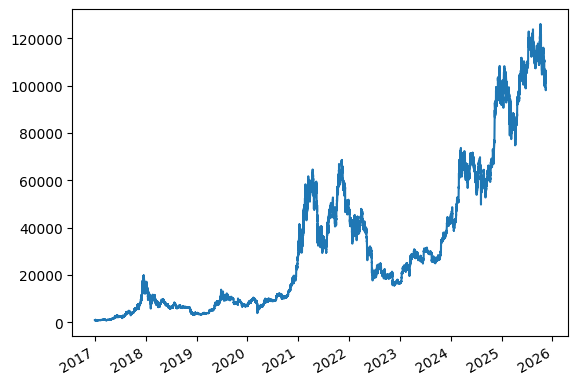

In [50]:
btc[btc.Ticker == "BTC"].Close.plot()

<Axes: >

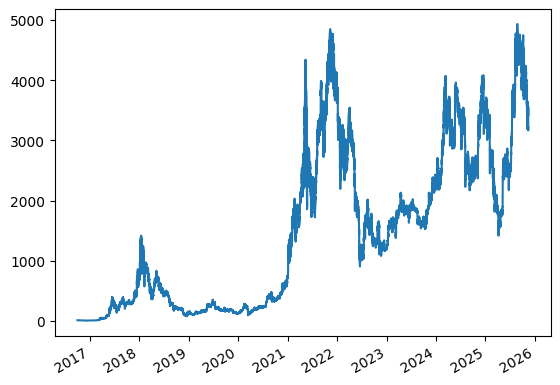

In [51]:
df_res[df_res.Ticker == "ETH"].Close.plot()

<Axes: >

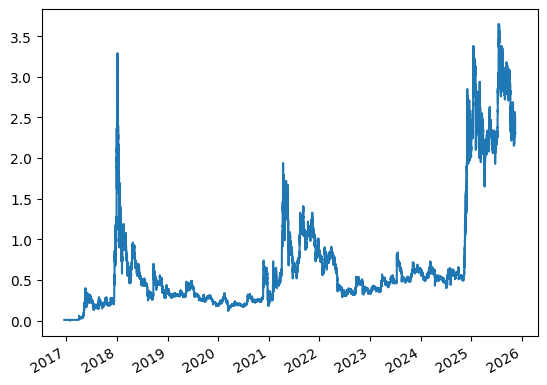

In [52]:
df_res[df_res.Ticker == "XRP"].Close.plot()

In [53]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275989 entries, 2011-08-18 12:37:00+00:00 to 2025-11-14 03:00:00+00:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Open                           275989 non-null  float64
 1   High                           275989 non-null  float64
 2   Low                            275989 non-null  float64
 3   Close                          275989 non-null  float64
 4   Volume                         275989 non-null  float64
 5   Ticker                         275989 non-null  object 
 6   Max_Price_in_future_24h        275920 non-null  float64
 7   growth_future_24h              275920 non-null  float64
 8   is_positive_growth_24h_future  275989 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 21.1+ MB


In [54]:
def save_data(df):
    """Save data to parquet files"""
    data_dir = os.path.join(os.getcwd(), "data")
    
    # Create data directory if it doesn't exist
    os.makedirs(data_dir, exist_ok=True)
    
    today = date.today().strftime("%Y%m%d")
    
    if not df.empty:
        file_path = os.path.join(data_dir, f"{today}_df_wTarget.parquet")
        try:
            df.to_parquet(file_path, compression="brotli")
            print(f"df_tar Saved to {file_path}")
        except Exception as e:
            print(f"Error saving df_tar: {e}")
    else:
        print(f"Warning: df_tar is empty, not saving")

In [55]:
save_data(df_res)

df_tar Saved to /home/baozh166/2025Fall_QR_Crypto/v2_2models_rag/notebooks/data/20251113_df_wTarget.parquet
